Import libraries

In [1]:
import ast
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import requests
from fuzzywuzzy import fuzz, process
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import Reader, Dataset, SVD, KNNBasic, accuracy

In [2]:
books = pd.read_csv("data//cleaned_books_info.csv", index_col = 0)
books.head()

,average_rating,description,publisher,num_pages,image_url,book_id,ratings_count,title,is_boardbook,WeightedRating,authors_id,title_words,desc_sentnce_count,desc_words,desc_word_count
0,4.15,Fashion goes to the dogs in this lovable follo...,Simon & Schuster Books for Young Readers,48,https://images.gr-assets.com/books/1343249491m...,13037808,942,Zorro Gets an Outfit,0,4.023908,676353,"['Zorro', 'Gets', 'Outfit']",11,"['Fashion', 'goes', 'to', 'the', 'dogs', 'in',...",128
1,3.75,Winter weather is keeping children from visiti...,Knopf Books for Young Readers,40,https://images.gr-assets.com/books/1320544663m...,11080564,471,ZooZical,0,3.996410,1241 25031,['ZooZical'],10,"['Winter', 'weather', 'is', 'keeping', 'childr...",171
2,3.93,The sequel to Gordon Korman's SWINDLE - the Ma...,Scholastic Press,256,https://images.gr-assets.com/books/1328839293m...,6620483,3907,"Zoobreak (Swindle, #2)",0,3.984889,2130,"['Zoobreak', 'Swindle']",5,"['The', 'sequel', 'to', 'Gordon', 'Korman', 'S...",87
3,3.70,How many different ways of walking can you nam...,Blue Apple Books,14,https://s.gr-assets.com/assets/nophoto/book/11...,1644081,22,Zoo Parade!,1,3.919211,6483 90091,"['Zoo', 'Parade']",12,"['How', 'many', 'different', 'ways', 'of', 'wa...",149
4,3.78,Trying to discover the truth about their eerie...,Scholastic Paperbacks,80,https://images.gr-assets.com/books/1360057751m...,312542,701,Zombies Don't Play Soccer (The Adventures of t...,0,3.992553,11639 11644,"['Zombies', ""n't"", 'Play', 'Soccer', 'Adventur...",1,"['Trying', 'to', 'discover', 'the', 'truth', '...",35


The weighted ratings in the books file was estimated in the analysis notebook using the formula, WeightedRating (WR)=(v/(v+m))R+(m/(v+m))C, where R = average rating of the book, v = number of ratings, m = minimum votes required to be listed, C = the mean vote across the whole dataset.

#### All time popular board books

In [3]:
bb_sorted = books.loc[(books.is_boardbook == 1),['title','WeightedRating']].sort_values(by = 'WeightedRating', ascending = False).reset_index(drop = True)
bb_sorted[:10]

,title,WeightedRating
0,Guess How Much I Love You,4.358199
1,"The Little Mouse, the Red Ripe Strawberry, and...",4.304665
2,The Very Hungry Caterpillar,4.289473
3,Hairy Maclary from Donaldson's Dairy,4.266747
4,Little Blue Truck,4.266129
5,Barnyard Dance,4.242683
6,The Best Mouse Cookie,4.234606
7,Each Peach Pear Plum,4.229718
8,The Going-To-Bed Book,4.214007
9,How Do I Love You?,4.197584


#### All time popular other books

In [4]:
ob_sorted = books.loc[(books.is_boardbook == 0),['title','WeightedRating']].sort_values(by = 'WeightedRating', ascending = False).reset_index(drop = True)
ob_sorted[:10]

,title,WeightedRating
0,Harry Potter and the Prisoner of Azkaban (Harr...,4.527644
1,The Monster at the End of this Book,4.416599
2,Wonder (Wonder #1),4.416414
3,The Complete Tales and Poems of Winnie-the-Poo...,4.401432
4,Wonder,4.401359
5,"You Are Special (Wemmicksville, #1)",4.375326
6,The Giving Tree,4.365783
7,The Kissing Hand,4.362315
8,Disney's the Lion King,4.352634
9,"A Grimm Warning (The Land of Stories, #3)",4.349086


#### Metadata / Content based Recommender

In [5]:
books = pd.read_csv("data//cleaned_books_info.csv", index_col = 0) 

Recommends by evaluating the similarity based on book description, title and authors.

In [6]:
def create_soup(x):
    return ' '.join(ast.literal_eval(x['desc_words']))+' '+' '.join(ast.literal_eval(x['title_words']))+' '+x['authors_id']

In [7]:
books['soup'] = books.apply(create_soup, axis = 1)

In [8]:
print(books.iloc[0]['soup'])

Fashion goes to the dogs in this lovable follow-up to Say Hello to Zorro Mister Bud and Zorro get along just great They wake up together have walk time together and take naps together But something is about to interrupt their schedule Zorro has to wear a fancy outfit Zorro is embarrassed mortified aghast Mr Bud tries to cheer him up but nothing works Everyone makes fun of Zorro and he refuses to participate in chew-on-a-stick time Mister Bud does n't know what to do But when another dog a very cool dog shows up in an outfit and does amazing tricks and beats all the other dogs in a race Zorro discovers that wearing clothes might not be so bad after all Everything is back on schedule Zorro Gets Outfit 676353


In [9]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books['soup'])
tfidf_matrix.shape

(5937, 30867)

In [10]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [11]:
indices = pd.Series(books.index, index=books['title'].str.lower())

In [12]:
def content_recommender(user_input, df=books, indices=indices):
    
    
    if user_input.lower() not in indices:
        Ratio = dict()
        for title in indices.index:
            Ratio[title] = fuzz.token_set_ratio(user_input.lower(), title)
        Ratio_sorted = sorted(Ratio.items(), key=lambda item: item[1], reverse=True)
        closest_title = Ratio_sorted[0][0]
        content_recommender(closest_title)    
    else:
        print(f"Title entered:",string.capwords(user_input))
        idx = indices[user_input.lower()]
        
    # pairwise similarity scores of all books with the book entered. Output as list of tuples.
        sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort books based on the cosine similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # select 10 most similar books. Ignore the first book.
        sim_scores = sim_scores[1:11]
        book_indices = [i[0] for i in sim_scores]
    # Top 10 book recommendations
        top = df[['title','WeightedRating','average_rating', 'image_url', 'is_boardbook']].iloc[book_indices]
    # Read the top 10 recommended book urls and print the images
        for i in top['image_url']:
            if i[31:38] != 'nophoto':
                response = requests.get(i)
                img = Image.open(BytesIO(response.content))
                plt.figure()
                plt.axis('off')
                print(plt.imshow(img))
        print("The Top 10 Recommended Books")
        print(top[['title','WeightedRating']].reset_index(drop = True))
    return None

Title entered: Disney's The Lion King
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
AxesImage(54,36;334.8x217.44)
The Top 10 Recommended Books
                                               title  WeightedRating
0                              The Three Little Pigs        4.152750
1                          James and the Giant Peach        4.009262
2                            James & The Giant Peach        4.007849
3  The Story of the Little Mole Who Went in Searc...        4.035703
4                                         Pocahontas        4.067143
5                                             WALL-E        4.018949
6  Baby Mickey's Nap: A Book About Touch (Baby's ...        3.884825
7                                 The Cat in the Hat        4.146369
8                   Nancy Drew: Girl Detective: #1-4        4.010000
9               The Girl Who Wouldn't Brush Her Hair        3.9

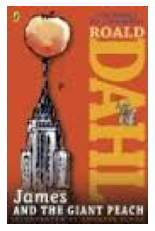

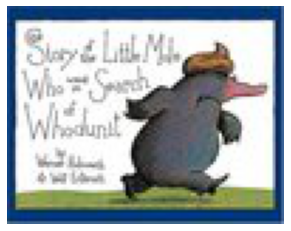

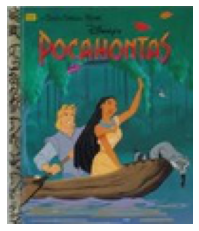

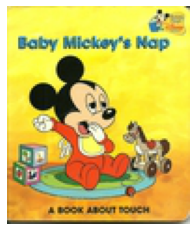

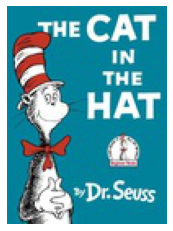

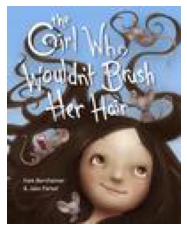

In [13]:
content_recommender('lion king')

#### Collaborative Filtering

In [14]:
ratings = pd.read_csv("data//cleaned_user_ratings_info", index_col = 0)
ratings.head()

,user_id,book_id,review_id,rating,date_updated,n_users_rated,n_books_rated
0,d1e368a7d2870eb6fbf6e0d350568a2d,23310161,87fb7685b0b1aa774cc14c330bdcfadf,4,Mon Aug 31 07:07:40 -0700 2015,1481,343
1,d1e368a7d2870eb6fbf6e0d350568a2d,1969280,3f21c462c88b57186b6f0c2becc121e2,3,Wed Sep 28 17:03:19 -0700 2016,462,343
2,d1e368a7d2870eb6fbf6e0d350568a2d,17290220,0a07041c829634236433f24409860be8,4,Wed Sep 28 16:45:23 -0700 2016,842,343
3,d1e368a7d2870eb6fbf6e0d350568a2d,231850,f1ed8ca9c5abfe0286f00b97d4d3965a,4,Tue Jan 05 19:13:00 -0800 2010,10215,343
4,d1e368a7d2870eb6fbf6e0d350568a2d,4948,285df57ea41be7f41d5a404d2ffad03a,5,Fri Jul 25 11:00:09 -0700 2014,18497,343


In [15]:
ratings.drop(columns = ['review_id','date_updated','n_users_rated', 'n_books_rated'], inplace = True)

In [16]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
svd = SVD()
# Run 5-fold cross-validation
cross_validate(svd, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7573  0.7547  0.7580  0.7567  0.7572  0.7568  0.0011  
Fit time          54.78   66.61   67.21   70.64   67.07   65.26   5.43    
Test time         2.75    2.71    2.77    2.73    2.64    2.72    0.04    


{'test_rmse': array([0.75731403, 0.75470543, 0.7580433 , 0.75669407, 0.75723872]),
 'fit_time': (54.775710582733154,
  66.60565185546875,
  67.21033263206482,
  70.63536190986633,
  67.06553792953491),
 'test_time': (2.749889612197876,
  2.7132022380828857,
  2.7681641578674316,
  2.729403495788574,
  2.6396048069000244)}

In [17]:
    #Tuning the SVD algorithm is very intensive process to perform with this laptop
    #traintest split and gridsearch cv for parameter tuning
trainset, testset = train_test_split(data, test_size=0.1)
param_grid = {'n_epochs': [10,20], 'lr_all': [0.005, 0.01]} #,"reg_all": [0.4, 0.6]
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
    # best RMSE score
print(gs.best_score['rmse'])
    # combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.7644634169372703
{'n_epochs': 20, 'lr_all': 0.005}


Best parameters after tuning turned to be same as the default values.

In [18]:
algo = gs.best_estimator['rmse']
algo.fit(trainset)
predictions = algo.test(testset)
    # compute RMSE
accuracy.rmse(predictions)

RMSE: 0.7514


0.7514109068647863

#### Hybrid Recommender

Using content recommender to find similar books based on the title, description and authors. Then using collaborative filtering to evaluate ratings of those books for the given user. Presenting the top 10 based on predicted rating.

In [19]:
def hybrid(userId = None, title_input = None):
    
    if title_input.lower() not in indices:
        Ratio = dict()
        for title in indices.index:
            Ratio[title] = fuzz.token_set_ratio(title_input.lower(), title)
        Ratio_sorted = sorted(Ratio.items(), key=lambda item: item[1], reverse=True)
        closest_title = Ratio_sorted[0][0]
        content_recommender(closest_title)    
    else:
        idx = indices[title_input.lower()]
        print(f"Title entered:",string.capwords(title_input))
    # Get the pairwsie similarity scores of all books with the book entered. Output as list of tuples.
        sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort books based on the cosine similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get 10 most similar books. Ignore the first book.
        sim_scores = sim_scores[1:26]
        book_indices = [i[0] for i in sim_scores]
    # Top 10 book recommendations
        top = books[['book_id','ratings_count','average_rating','num_pages','publisher','title','WeightedRating' ,'image_url']].iloc[book_indices]

    #Compute the predicted ratings using the SVD filter
        top['predicted_rating'] = top['book_id'].apply(lambda x: svd.predict(userId, x).est)
    
    #Sort the books in decreasing order of predicted rating
        top = top.sort_values('predicted_rating', ascending=False).reset_index(drop = True)
        print(top[['title', 'publisher','num_pages']].head(10))
    # Read the top 10 recommended book urls and print the images
        for i in top['image_url'][:10]:
            if i[31:38] != 'nophoto':
                response = requests.get(i)
                img = Image.open(BytesIO(response.content))
                plt.figure()
                plt.axis('off')
                print(plt.imshow(img))
    return None

Title entered: The Lion And The Mouse
                                               title  \
0  Armstrong: The Adventurous Journey of a Mouse ...   
1                         Aesop's Illustrated Fables   
2                               A Lion in the Meadow   
3              Lindbergh: The Tale of a Flying Mouse   
4                                    The Lion Inside   
5                                  By Mouse and Frog   
6  The Little Mouse, the Red Ripe Strawberry, and...   
7                   Library Mouse (Library Mouse #1)   
8                                 The Butterfly Lion   
9                                  The Ugly Duckling   

                        publisher  num_pages  
0                NorthSouth Books        128  
1              Barnes & Noble Inc        456  
2                      Puffin Bks         26  
3                NorthSouth Books         96  
4                   Orchard Books         32  
5  Viking Books for Young Readers         40  
6      Child's P

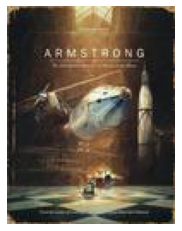

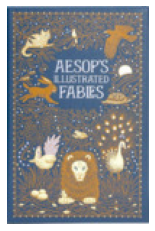

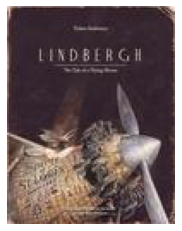

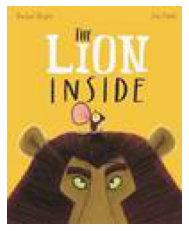

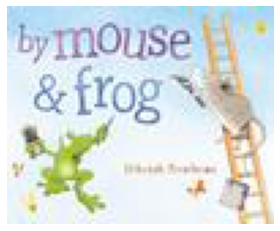

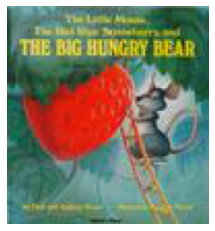

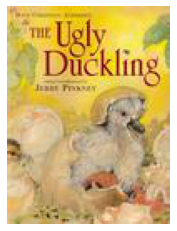

In [20]:
hybrid(userId = '906e8375407cdbeb743d86e66f1aebb2', title_input = "The Lion and the Mouse")